In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


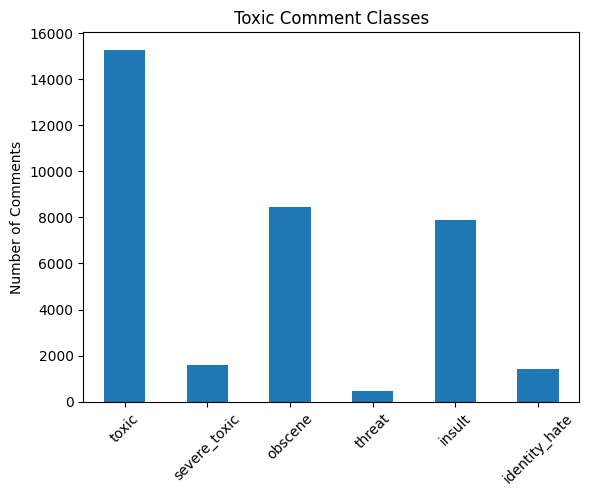

📊 Naive Bayes Classification Report:

               precision    recall  f1-score   support

        toxic       0.94      0.49      0.64      3056
 severe_toxic       0.67      0.11      0.19       321
      obscene       0.91      0.48      0.63      1715
       threat       0.00      0.00      0.00        74
       insult       0.85      0.40      0.54      1614
identity_hate       0.65      0.04      0.08       294

    micro avg       0.90      0.43      0.58      7074
    macro avg       0.67      0.25      0.35      7074
 weighted avg       0.88      0.43      0.57      7074
  samples avg       0.04      0.03      0.04      7074


📊 Logistic Regression Classification Report:

               precision    recall  f1-score   support

        toxic       0.90      0.63      0.74      3056
 severe_toxic       0.56      0.24      0.33       321
      obscene       0.92      0.62      0.74      1715
       threat       0.63      0.16      0.26        74
       insult       0.83      0

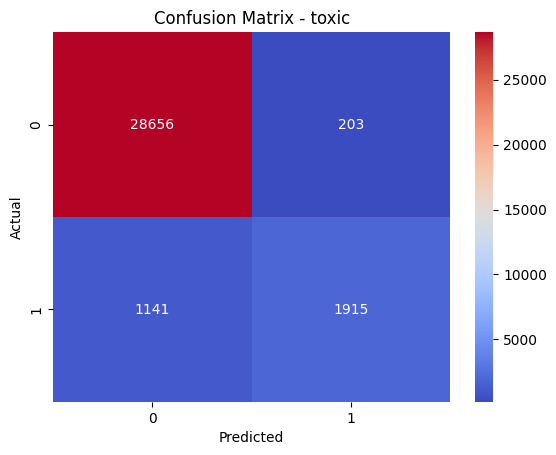

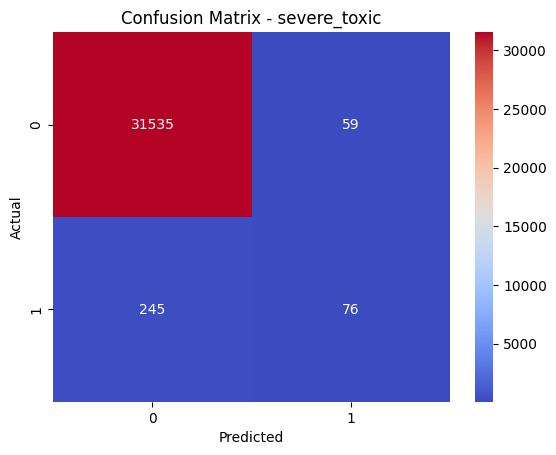

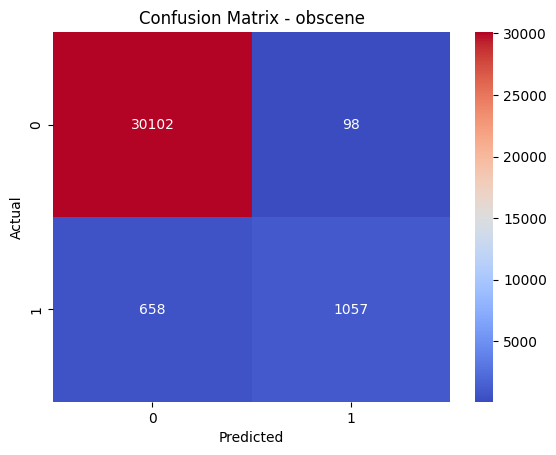

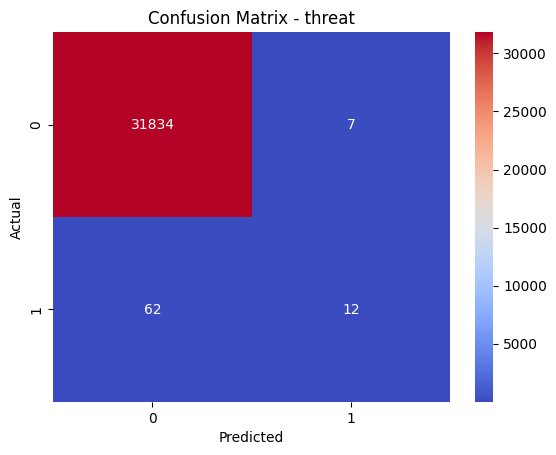

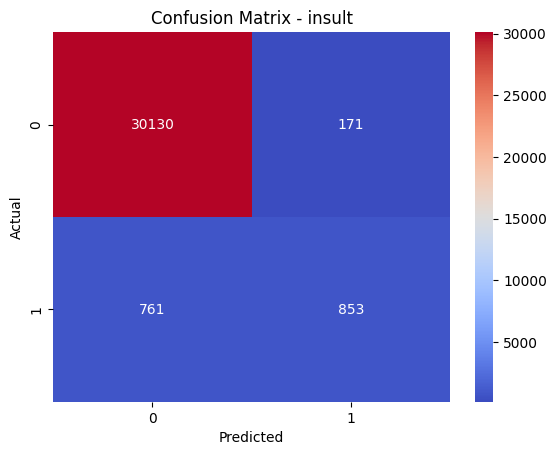

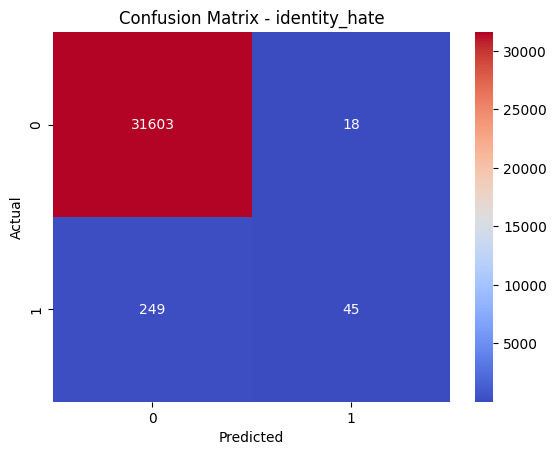

✅ Best Params for Toxic Class: {'C': 10}

📊 Tuned Logistic Regression Report (Toxic Class Only):

              precision    recall  f1-score   support

   Non-Toxic       0.97      0.99      0.98     28859
       Toxic       0.86      0.70      0.77      3056

    accuracy                           0.96     31915
   macro avg       0.92      0.84      0.87     31915
weighted avg       0.96      0.96      0.96     31915



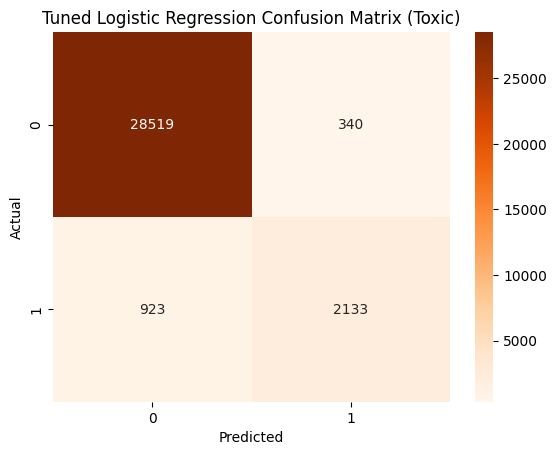

In [9]:
# 📦 Full Toxic Comment Classification Pipeline (Single Cell)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import numpy as np

# 📥 Step 1: Load Dataset
# Use the provided path for the zip file containing train.csv
df = pd.read_csv("/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/train.csv")
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df = df[['comment_text'] + label_cols]

# 🧹 Step 2: Clean Text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_text'] = df['comment_text'].apply(clean_text)

# 📊 Step 3: Visualize Class Distribution
df[label_cols].sum().plot(kind='bar', title='Toxic Comment Classes')
plt.xticks(rotation=45)
plt.ylabel("Number of Comments")
plt.show()

# ✂️ Step 4: Split Data
X = df['clean_text']
y = df[label_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔢 Step 5: TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# 🤖 Step 6: Multinomial Naive Bayes (Multi-label)
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier

nb_model = MultiOutputClassifier(MultinomialNB())
nb_model.fit(X_train_vec, y_train)
nb_pred = nb_model.predict(X_test_vec)

print("📊 Naive Bayes Classification Report:\n")
print(classification_report(y_test, nb_pred, target_names=label_cols))

# 🤖 Step 7: Logistic Regression (Multi-label)
lr_model = MultiOutputClassifier(LogisticRegression())
lr_model.fit(X_train_vec, y_train)
lr_pred = lr_model.predict(X_test_vec)

print("\n📊 Logistic Regression Classification Report:\n")
print(classification_report(y_test, lr_pred, target_names=label_cols))

# 📉 Confusion Matrices
for idx, label in enumerate(label_cols):
    # Check if the predicted labels are all the same for a class
    if len(np.unique(lr_pred[:, idx])) > 1:
        cm = multilabel_confusion_matrix(y_test.iloc[:, idx], lr_pred[:, idx])[1]
        sns.heatmap(cm.reshape(2, 2), annot=True, fmt='d', cmap='coolwarm')
        plt.title(f'Confusion Matrix - {label}')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()
    else:
        print(f"Skipping confusion matrix for '{label}' due to single predicted class.")


# 🔍 Step 8: Hyperparameter Tuning (Logistic Regression for toxic class only)
from sklearn.model_selection import GridSearchCV

# Tuning for just one label ('toxic') to keep runtime manageable
grid = GridSearchCV(LogisticRegression(), {'C': [0.01, 0.1, 1, 10, 100]}, scoring='f1', cv=3)
grid.fit(X_train_vec, y_train['toxic'])

print("✅ Best Params for Toxic Class:", grid.best_params_)

# Evaluate tuned model for 'toxic'
toxic_preds_tuned = grid.predict(X_test_vec)
print("\n📊 Tuned Logistic Regression Report (Toxic Class Only):\n")
print(classification_report(y_test['toxic'], toxic_preds_tuned, target_names=['Non-Toxic', 'Toxic']))

# Confusion Matrix for tuned 'toxic'
from sklearn.metrics import confusion_matrix
# Check if the predicted labels are all the same for the 'toxic' class
if len(np.unique(toxic_preds_tuned)) > 1:
    cm_tuned = confusion_matrix(y_test['toxic'], toxic_preds_tuned)
    sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Oranges')
    plt.title("Tuned Logistic Regression Confusion Matrix (Toxic)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
else:
    print("Skipping tuned confusion matrix for 'toxic' due to single predicted class.")

In [10]:
import joblib

joblib.dump(grid.best_estimator_, 'logistic_model_tuned.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

print("✅ Model and Vectorizer saved successfully.")


✅ Model and Vectorizer saved successfully.


In [11]:
# 🔮 Function to predict comment label using the trained model
def predict_comment(text):
    # Reuse the same cleaning steps as earlier
    def clean_text(text):
        text = text.lower()
        text = re.sub(r"http\S+", "", text)
        text = re.sub(r"@\w+", "", text)
        text = re.sub(r"#\w+", "", text)
        text = re.sub(r"[^a-z\s]", "", text)
        text = re.sub(r"\s+", " ", text).strip()
        return text

    cleaned = clean_text(text)
    vectorized = vectorizer.transform([cleaned])
    prediction = grid.predict(vectorized)[0]

    label_map = {0: 'Hate Speech', 1: 'Offensive', 2: 'Neutral'}
    return label_map[prediction]

# 🔁 Predict multiple inputs interactively
print("🔁 Real-time Toxic Comment Classifier (type 'q' to quit)\n")
while True:
    user_input = input("Enter a comment: ")
    if user_input.lower() == 'q':
        print("👋 Exiting prediction loop.")
        break
    print("🔍 Predicted Label:", predict_comment(user_input))
    print("-" * 50)


🔁 Real-time Toxic Comment Classifier (type 'q' to quit)

Enter a comment: i hate u 
🔍 Predicted Label: Offensive
--------------------------------------------------
Enter a comment: q
👋 Exiting prediction loop.
